In [1]:
%matplotlib inline

In [2]:
from glob import glob
from kid_readout.measurement import core
from kid_readout.measurement.io import npy
from kid_readout.analysis.timeseries import binning

In [3]:
npy_files = sorted(glob('*sweep_stream_on_off.npy'))
npy_files

['2016-10-14_184754_sweep_stream_on_off.npy',
 '2016-10-17_204527_sweep_stream_on_off.npy',
 '2016-10-18_124841_sweep_stream_on_off.npy',
 '2016-10-18_161556_sweep_stream_on_off.npy',
 '2016-10-18_192815_sweep_stream_on_off.npy',
 '2016-10-19_144701_sweep_stream_on_off.npy',
 '2016-10-19_180723_sweep_stream_on_off.npy',
 '2016-10-19_204329_sweep_stream_on_off.npy',
 '2016-10-21_141843_sweep_stream_on_off.npy',
 '2016-10-21_161825_sweep_stream_on_off.npy',
 '2016-10-25_141727_sweep_stream_on_off.npy']

In [4]:
plot_directory = '/home/flanigan/temp/'

In [5]:
all_data = pd.concat([pd.DataFrame.from_records(np.load(f)) for f in npy_files], ignore_index=True)
all_data.shape

(308, 76)

In [6]:
magnet = all_data[all_data['magnet_array_distance_from_base_mm'].notnull()].sort_values(by='sweep_temperature_package')

In [7]:
lo_index = 0
attenuation = 20

chosen = magnet[(magnet.lo_index==lo_index) & (magnet.roach_dac_attenuation==attenuation)]
chosen.shape

(10, 76)

In [49]:
1e6 / chosen.res_Q_i

56      11.107556
28      10.439797
84      11.262011
112     12.535635
140     16.369615
168     24.052684
196     39.082513
224     54.547640
252     77.337119
280    106.402149
Name: res_Q_i, dtype: float64

In [8]:
chosen.res_Q_e

56     (19793.8081481-78.7510921545j)
28     (19760.0101495-121.418369684j)
84     (19769.5837618-128.228989236j)
112    (19732.6589261-194.862832997j)
140    (19653.9440681-281.798904894j)
168    (19616.5338603-372.362440441j)
196    (19703.9951606-579.308519796j)
224     (19870.1625467-500.24736071j)
252    (20056.1402497-484.900009541j)
280    (20225.0478414-527.563508993j)
Name: res_Q_e, dtype: complex128

In [9]:
root_path_110_mK = '/data/detectors/2016-10-17_204527_sweep_stream_on_off/'
node_path = chosen[chosen.root_path==root_path_110_mK].iloc[0].node_path
node_path

'/SingleSweepStream0'

In [10]:
npd = npy.NumpyDirectory(root_path=root_path_110_mK)
sss = npd.read(node_path)

# $x$ and $1 / Q_i$ vs. $T$

In [11]:
x_color = 'blue'
i_color = 'red'

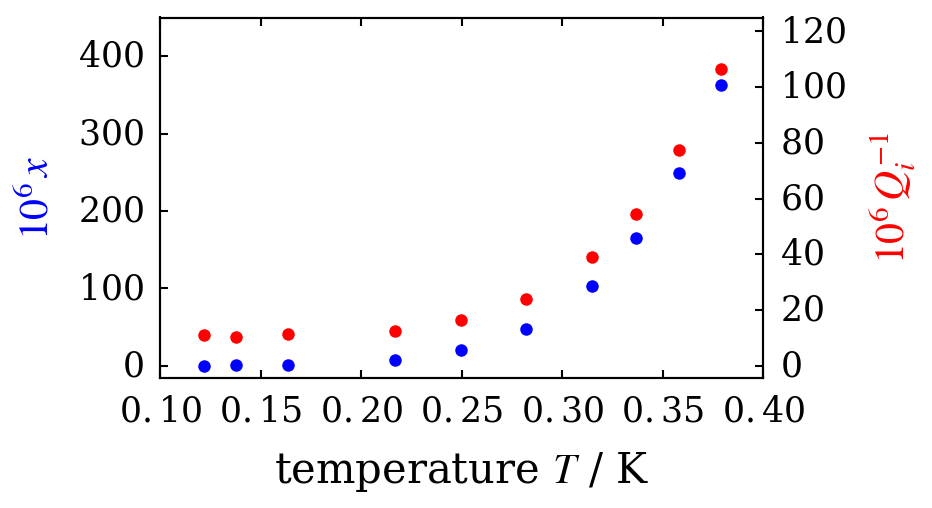

In [50]:
fig, x_ax = plt.subplots()
i_ax = x_ax.twinx()
x_ax.set_xlabel(r'temperature $T$ / K')
x_ax.set_ylabel(r'$10^6 \, x$', color=x_color)
i_ax.set_ylabel(r'$10^6 \, Q_i^{-1}$', color=i_color)
x_ax.plot(chosen.temperature_package,
          1e6 * (chosen.res_f_0.max() / chosen.res_f_0 - 1),
          marker='o', color=x_color,
          linestyle='none')
i_ax.plot(chosen.temperature_package,
          1e6 * chosen.res_Q_i**-1,
          marker='o', color=i_color,
          linestyle='none')
x_ax.set_xlim(0.1, 0.4)
x_ax.set_ylim(-15, 450)
i_ax.set_ylim(-15 * 125 / 450, 125)

fig.savefig(plot_directory + 'x_and_iQi_vs_T_index_0.pdf')

# $S_{xx}$ vs. $f$

In [13]:
def make_mask(frequency, to_mask, width):
    mask = np.ones(frequency.size, dtype=np.bool)
    for f in to_mask:
        indices = np.abs(frequency - f) < width
        mask[indices] = False
    return mask

def log_bin_noise(frequency, data):
    log_bin_edges = binning.log_bin_edges(frequency, bins_per_decade=30, ensure_none_empty=False)
    bin_indices = np.digitize(frequency, log_bin_edges)
    frequency_binned = np.array([frequency[bin_indices==n].mean() for n in range(1, bin_indices.size)])
    data_binned = np.array([data[bin_indices==n].mean() for n in range(1, bin_indices.size)])
    nan_mask = np.logical_not(np.isnan(frequency_binned))
    return frequency_binned[nan_mask], data_binned[nan_mask]

In [16]:
sss.set_q_and_x(deglitch=True)

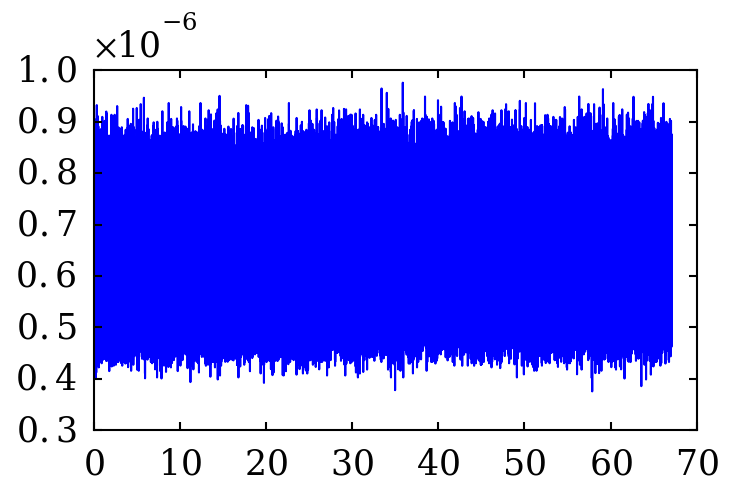

In [17]:
fig, ax = plt.subplots()
ax.plot(sss.stream.sample_time, sss.x)

In [18]:
sss.set_S(window=plt.mlab.window_hanning, detrend=plt.mlab.detrend_none, binned=False)

(140, 145)

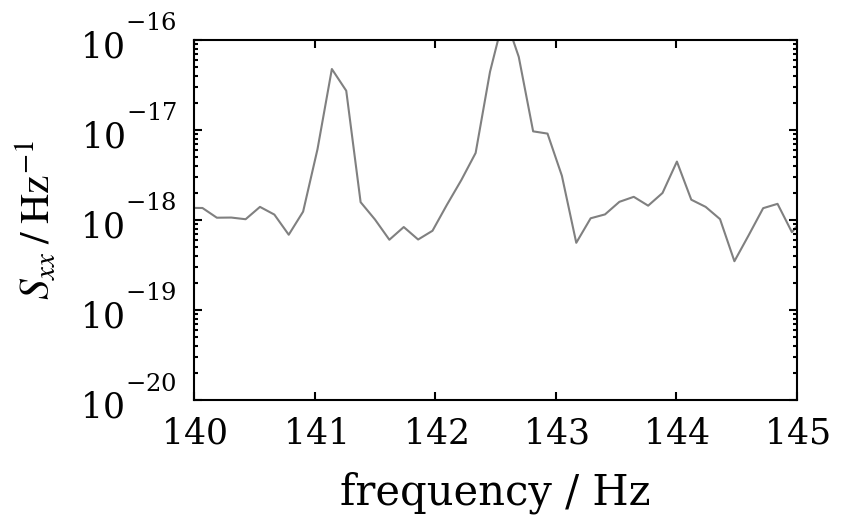

In [40]:
fig, ax = plt.subplots()
#ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency / Hz')
ax.set_ylabel('$S_{xx} \; / \; \mathrm{Hz}^{-1}$')
ax.plot(sss.S_frequency, sss.S_xx, '-', color='gray')
ax.set_ylim(1e-20, 1e-16)
ax.set_xlim(140, 145)

In [41]:
f_mask = make_mask(sss.S_frequency, to_mask=[141.25, 142.5, 7812.5], width=0.5)
f_binned, S_xx_binned = log_bin_noise(sss.S_frequency[f_mask], sss.S_xx[f_mask])

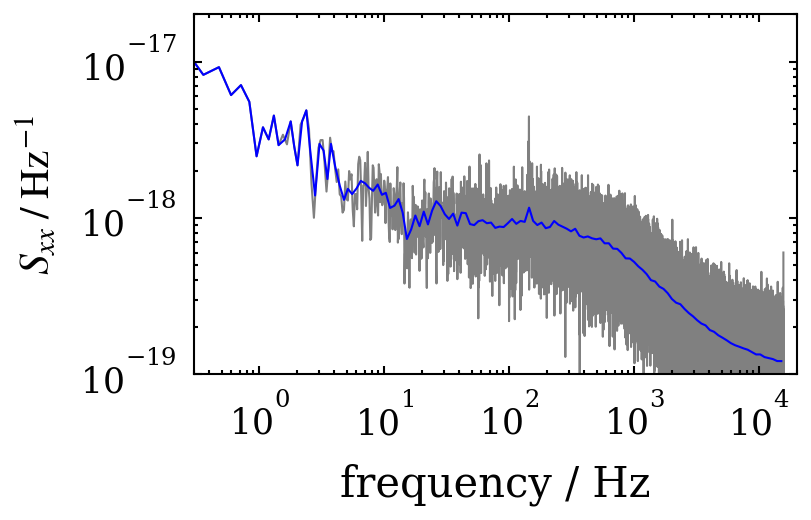

In [51]:
fig, ax = plt.subplots()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('frequency / Hz')
ax.set_ylabel('$S_{xx} \; / \; \mathrm{Hz}^{-1}$')
ax.plot(sss.S_frequency[f_mask], sss.S_xx[f_mask], '-', color='gray')
ax.plot(f_binned, S_xx_binned, '-', color=x_color)
ax.set_xlim(3e-1, 2e4)
ax.set_ylim(1e-19, 2e-17)

fig.savefig(plot_directory + 'Sxx_vs_f_without_warts_index_0.pdf')

In [52]:
chosen.temperature_package

56     0.121956
28     0.137713
84     0.163422
112    0.216902
140    0.249456
168    0.282179
196    0.314823
224    0.336439
252    0.357949
280    0.379092
Name: temperature_package, dtype: float64